In [1]:
# required to import local package

import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import torch
from ogb.nodeproppred import PygNodePropPredDataset

# download dataset using ogb pytorch geometric loader.
dataset = PygNodePropPredDataset(name="ogbn-arxiv")

data = dataset[0] # pyg graph object

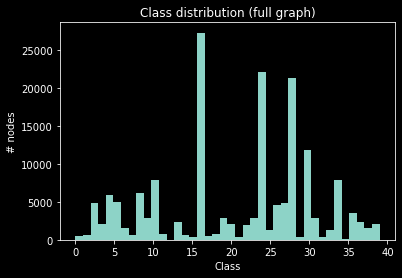

In [3]:
import matplotlib.pyplot as plt

plt.title("Class distribution (full graph)")
plt.hist(data.y.reshape(-1).detach().numpy(), dataset.num_classes)
plt.xlabel("Class")
plt.ylabel("# nodes")
plt.show()

graph is strongly connected component: False
graph is weakly connected component: True
graph has # weakly connected components: 1
graph has # isolated nodes: 0


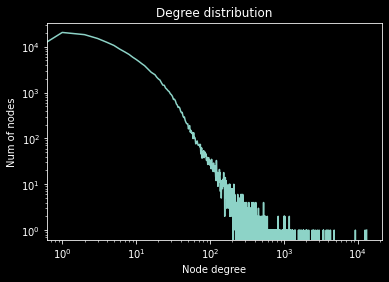

In [5]:
from lib import util

util.describe_graph(data, log_scale=True)

## Split data set

In [6]:
from lib.data import split_dataset

train_data, calibration_indices, test_indices = split_dataset(data, 0.2, 0.2)

print("Train set: {}".format(train_data))
print("Calibration set size: {}".format(len(calibration_indices)))
print("Test set size: {}".format(len(test_indices)))

Train set: Data(x=[108380, 128], edge_index=[2, 472649], y=[108380, 1])
Calibration set size: 27095
Test set size: 33868


## Inspect Train set

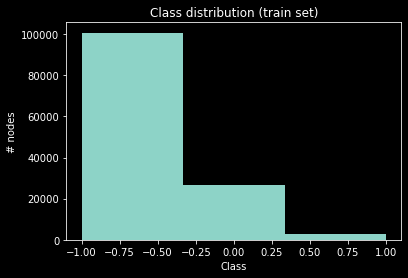

In [ ]:
plt.title("Class distribution (train set)")
plt.hist(train_data.y.reshape(-1).detach().numpy(), dataset.num_classes)
plt.xlabel("Class")
plt.ylabel("# nodes")
plt.show()

graph is strongly connected component: False
graph is weakly connected component: False
graph has # weakly connected components: 40023
graph has # isolated nodes: 24490


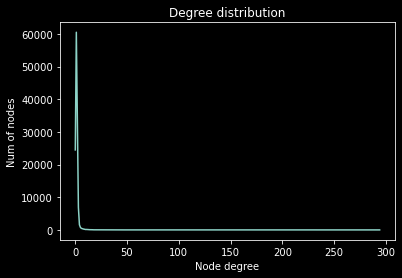

In [ ]:
util.describe_graph(train_data)

## Inspect calibration data

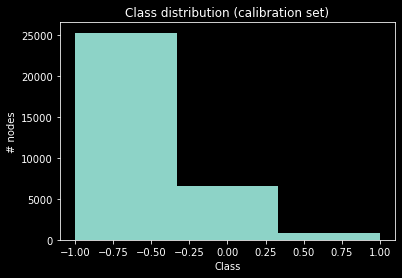

In [ ]:
plt.title("Class distribution (calibration set)")
plt.hist(data.y[calibration_indices].reshape(-1).detach().numpy(), dataset.num_classes)
plt.xlabel("Class")
plt.ylabel("# nodes")
plt.show()

## Inspect test data

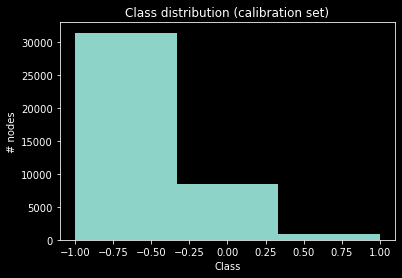

In [ ]:
plt.title("Class distribution (calibration set)")
plt.hist(data.y[test_indices].reshape(-1).detach().numpy(), num_classes)
plt.xlabel("Class")
plt.ylabel("# nodes")
plt.show()

# GraphSAGE model

In [ ]:
from lib.graphsage import GraphSAGE
from lib.evaluation import get_binary_classification_performance

args = {
    "num_layers": 1,
    "hidden_dim": 512,
    "lr": 0.01, # learning rate
    "epochs": 15,
    "batch_size": 128,
    "num_neighbors": [1],
    "max_stagnation": 15,
}

model = GraphSAGE(data.num_features, args["hidden_dim"], data.num_classes, args["num_layers"], args["num_neighbors"])


# reset the parameters to initial random value
model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])

nll_loss = torch.nn.NLLLoss(weight=torch.tensor([0.2,1])) # negative log-likelihood
def custom_loss_fn(y_hat, y_true):
  known_class_indices = y_true != -1 # only look at nodes with known classes
  return nll_loss(y_hat[known_class_indices], y_true[known_class_indices])

loss_fn = custom_loss_fn

for epoch in range(1, 1 + args["epochs"]):
    print(f"Epoch: {epoch:02d}")
    loss = model.train_model(train_data, optimizer, loss_fn, args["batch_size"])
    
# evaluate
model.eval()

y_hat = model.predict(data)
y_hat = y_hat[test_indices]
y_hat = y_hat.argmax(dim=-1, keepdim=True).reshape(-1)

y_true = data.y[test_indices].reshape(-1)

known_class_mask = y_true != -1
test_acc, test_f1_class_0, test_f1_class_1 = get_binary_classification_performance(y_hat[known_class_mask], y_true[known_class_mask])

print(f"Model found \n"
        f"Test acc: {100 * test_acc:.2f}%, "
        f"Test f1 (class 0): {100 * test_f1_class_0:.2f}%, "
        f"Test f1 (class 1): {100 * test_f1_class_1:.2f}%")

Epoch: 01
Epoch: 02
Epoch: 03
Epoch: 04
Epoch: 05
Epoch: 06
Epoch: 07
Epoch: 08
Epoch: 09
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Model found 
Test acc: 95.33%, Test f1 (class 0): 97.45%, Test f1 (class 1): 72.64%


### Performance per node (in-)degreee

/usr/local/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(

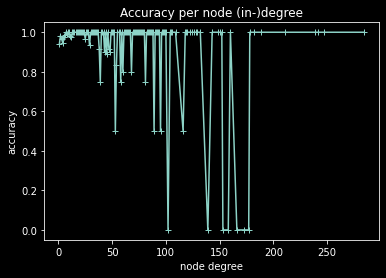

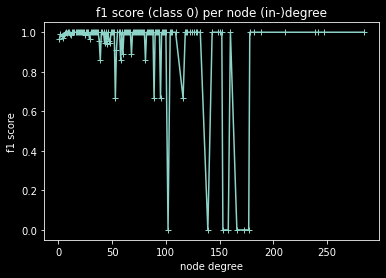

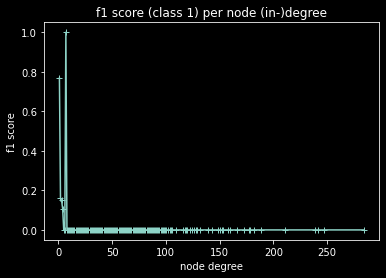

In [ ]:
from lib.util import plot

y_hat = model.predict(data)
y_hat = y_hat.argmax(dim=-1, keepdim=True).reshape(-1)
y_true = data.y.reshape(-1)

node_idx, node_degree = torch.unique(data.edge_index[1], return_counts=True)
nd = torch.zeros(data.x.shape[0]).long()
nd[node_idx] = node_degree

degrees = torch.unique(node_degree)

degrees_with_samples = []
accs = []
f1_scores_class_0 = []
f1_scores_class_1 = []
for d in degrees:
  degree_mask = torch.logical_and(nd == d, y_true != -1)
  if y_hat[degree_mask].shape[0] > 0:
    acc, f1_class_0, f1_class_1 = get_binary_classification_performance(y_hat[degree_mask], y_true[degree_mask])

    degrees_with_samples.append(d)
    accs.append(acc)
    f1_scores_class_0.append(f1_class_0)
    f1_scores_class_1.append(f1_class_1)

plot("Accuracy per node (in-)degree", degrees_with_samples, accs, "node degree", "accuracy")
plot("f1 score (class 0) per node (in-)degree", degrees_with_samples, f1_scores_class_0, "node degree", "f1 score")
plot("f1 score (class 1) per node (in-)degree", degrees_with_samples, f1_scores_class_1, "node degree", "f1 score")

# Conformal prediction (standard)

In [ ]:
from lib.conformal_predictor import ConformalClassifier, get_nonconformity_measure_for_classification

cal_y_hat = model.predict(data)
cal_y_hat = cal_y_hat[calibration_indices]
y_true = data.y[calibration_indices]
cal_y_hat = cal_y_hat[y_true != -1]
y_true = y_true[y_true != -1]
y_true = y_true.reshape(-1).detach()

cal_alphas = []
for y_probas, yt in zip(cal_y_hat,y_true):
  y = yt.item()
  a = get_nonconformity_measure_for_classification(y_probas.detach(), y)
  cal_alphas.append(a)

cal_alphas = torch.tensor(cal_alphas)
cal_y = y_true

cp = ConformalClassifier(cal_alphas, cal_y)

## coverage and efficiency

In [ ]:
from lib.evaluation import get_coverage_and_efficiency

CONFIDENCE_LEVEL = 0.95

def get_confidence_intervals(cp, y_hat, confidence_level=0.95, mondrian_category=None):
  confidence_intervals = []
  for yi in y_hat:
    ci = cp.predict(yi, confidence_level, mondrian_category)
    confidence_intervals.append(ci)
  
  return confidence_intervals

y_hat = model.predict(data)
y_true = data.y
# get test indices
y_hat = y_hat[test_indices]
y_true = y_true[test_indices]

### Overall

In [ ]:
from lib.util import print_percentage

known_class_indices = y_true != -1

confidence_intervals = get_confidence_intervals(cp, y_hat[known_class_indices], CONFIDENCE_LEVEL)


coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true[known_class_indices])

def print_coverage_and_efficiency(coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred):
  print_percentage("Coverage", coverage)
  print("Avg prediction set size: {:.2f}".format(avg_prediction_set_size))
  print_percentage("Singleton predictions", frac_singleton_pred)
  print_percentage("Empty predictions", frac_empty_pred)

print_percentage("Confidence level", CONFIDENCE_LEVEL)
print_coverage_and_efficiency(coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred)

Confidence level: 95.00%
Coverage: 95.08%
Avg prediction set size: 0.99
Singleton predictions: 99.43%
Empty predictions: 0.57%


### Per class

In [ ]:
# class 0
class_0_indices = y_true == 0

confidence_intervals = get_confidence_intervals(cp, y_hat[class_0_indices], CONFIDENCE_LEVEL)

coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true[class_0_indices])

print("CLASS 0")
print_coverage_and_efficiency(coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred)

# class 1
class_1_indices = y_true == 1

confidence_intervals = get_confidence_intervals(cp, y_hat[class_1_indices], CONFIDENCE_LEVEL)

coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true[class_1_indices])

print("CLASS 1")
print_coverage_and_efficiency(coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred)

CLASS 0
Coverage: 98.42%
Avg prediction set size: 1.00
Singleton predictions: 99.65%
Empty predictions: 0.35%
CLASS 1
Coverage: 63.50%
Avg prediction set size: 0.97
Singleton predictions: 97.43%
Empty predictions: 2.57%


### per node (in-)degree

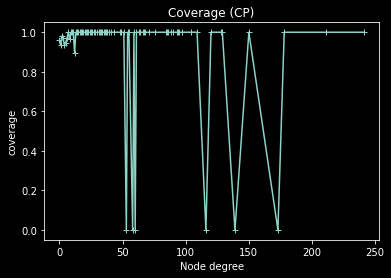

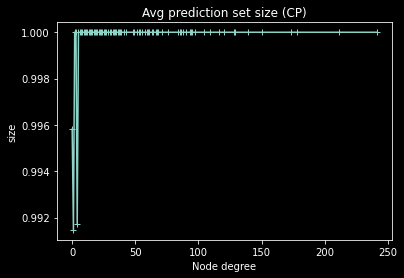

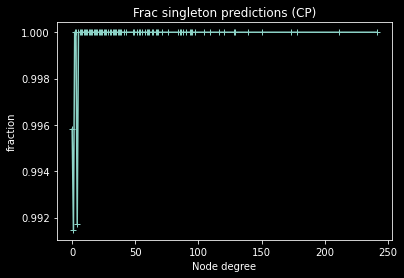

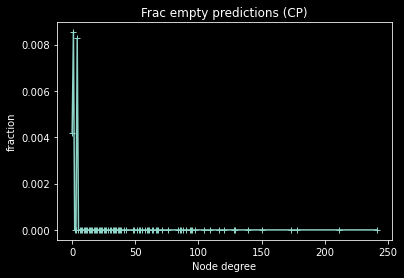

In [ ]:
node_idx, node_degree = torch.unique(data.edge_index[1], return_counts=True)
nd = torch.zeros(data.x.shape[0]).long()
nd[node_idx] = node_degree
# only keep test indices
nd = nd[test_indices]

degrees = torch.unique(nd)

degrees_with_samples = []
coverages = []
avg_prediction_set_sizes = []
frac_singleton_preds = []
frac_empty_preds = []
for d in degrees:
  degree_mask = torch.logical_and(nd == d, y_true != -1)
  if y_true[degree_mask].shape[0] == 0:
    continue

  confidence_intervals = get_confidence_intervals(cp, y_hat[degree_mask], CONFIDENCE_LEVEL)
  
  coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true[degree_mask])

  degrees_with_samples.append(d)
  coverages.append(coverage)
  avg_prediction_set_sizes.append(avg_prediction_set_size)
  frac_singleton_preds.append(frac_singleton_pred)
  frac_empty_preds.append(frac_empty_pred)

save_plot = False
x_label = "Node degree"
plot("Coverage (CP)", degrees_with_samples, coverages, x_label, "coverage", save_plot)
plot("Avg prediction set size (CP)", degrees_with_samples, avg_prediction_set_sizes, x_label, "size", save_plot)
plot("Frac singleton predictions (CP)", degrees_with_samples, frac_singleton_preds, x_label, "fraction", save_plot)
plot("Frac empty predictions (CP)", degrees_with_samples, frac_empty_preds, x_label, "fraction", save_plot)

# Mondrian Conformal Prediction (MCP) (class-based)

In [ ]:
mcp_class = ConformalClassifier(cal_alphas, cal_y, True)

## Performance
### Overall

In [ ]:
known_class_indices = y_true != -1

confidence_intervals = get_confidence_intervals(mcp_class, y_hat[known_class_indices], CONFIDENCE_LEVEL)

coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true[known_class_indices])

print_percentage("Confidence level", CONFIDENCE_LEVEL)
print_coverage_and_efficiency(coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred)


Confidence level: 95.00%
Coverage: 95.85%
Avg prediction set size: 1.88
Singleton predictions: 11.52%
Empty predictions: 0.00%


### Per class

In [ ]:
# class 0
class_0_indices = y_true == 0

confidence_intervals = get_confidence_intervals(mcp_class, y_hat[class_0_indices], CONFIDENCE_LEVEL)

coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true[class_0_indices])

print("CLASS 0")
print_coverage_and_efficiency(coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred)

# class 1
class_1_indices = y_true == 1

confidence_intervals = get_confidence_intervals(mcp_class, y_hat[class_1_indices], CONFIDENCE_LEVEL)

coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true[class_1_indices])

print("CLASS 1")
print_coverage_and_efficiency(coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred)

CLASS 0
Coverage: 95.41%
Avg prediction set size: 1.95
Singleton predictions: 4.59%
Empty predictions: 0.00%
CLASS 1
Coverage: 100.00%
Avg prediction set size: 1.23
Singleton predictions: 77.01%
Empty predictions: 0.00%


### Per node (in-)degree

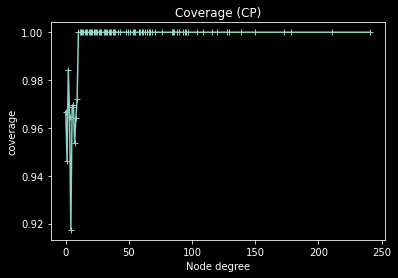

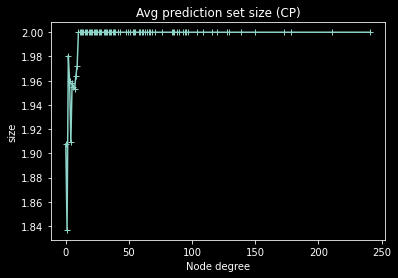

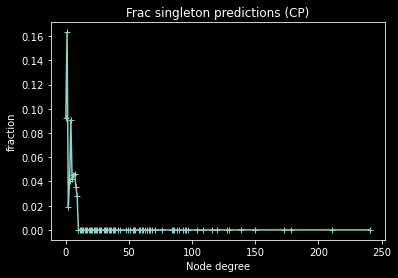

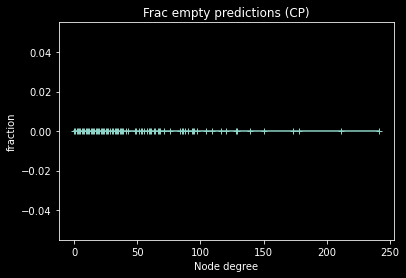

In [ ]:
degrees_with_samples = []
coverages = []
avg_prediction_set_sizes = []
frac_singleton_preds = []
frac_empty_preds = []
for d in degrees:
  degree_mask = torch.logical_and(nd == d, y_true != -1)
  if y_true[degree_mask].shape[0] == 0:
    continue

  confidence_intervals = get_confidence_intervals(mcp_class, y_hat[degree_mask], CONFIDENCE_LEVEL)
  
  coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true[degree_mask])

  degrees_with_samples.append(d)
  coverages.append(coverage)
  avg_prediction_set_sizes.append(avg_prediction_set_size)
  frac_singleton_preds.append(frac_singleton_pred)
  frac_empty_preds.append(frac_empty_pred)

save_plot = False
x_label = "Node degree"
plot("Coverage (CP)", degrees_with_samples, coverages, x_label, "coverage", save_plot)
plot("Avg prediction set size (CP)", degrees_with_samples, avg_prediction_set_sizes, x_label, "size", save_plot)
plot("Frac singleton predictions (CP)", degrees_with_samples, frac_singleton_preds, x_label, "fraction", save_plot)
plot("Frac empty predictions (CP)", degrees_with_samples, frac_empty_preds, x_label, "fraction", save_plot)

# MCP (node (in-)degree based)

In [ ]:
BINS = torch.tensor([0,1,2,5])

# get node degrees
c_node_ids, c_node_degrees = torch.unique(data.edge_index[1], return_counts=True)
cal_node_degrees = torch.zeros(data.x.shape[0]).long()
cal_node_degrees[c_node_ids] = c_node_degrees

cal_node_degrees = cal_node_degrees[calibration_indices] # only use calibration nodes


c_node_degrees_bins = torch.bucketize(cal_node_degrees, BINS)

calibration_taxonomy = c_node_degrees_bins[data.y[calibration_indices] != -1]

mcp_node_degree = ConformalClassifier(cal_alphas, cal_y, True, calibration_taxonomy)

### Performance per node degree bucket

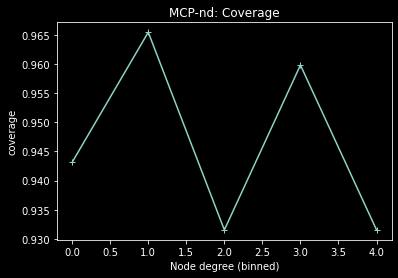

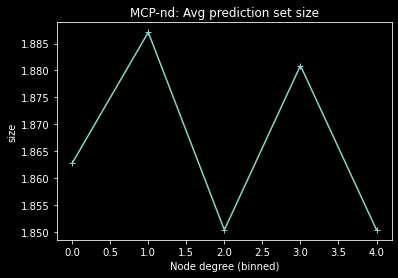

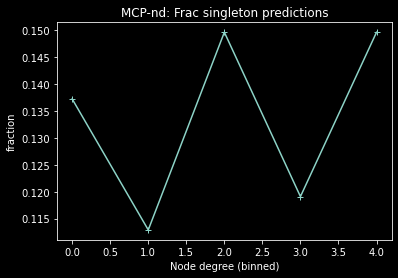

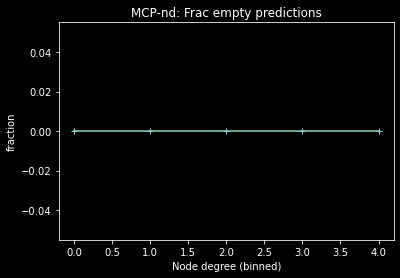

In [ ]:
nd_bins = torch.bucketize(nd, BINS)

degrees = torch.unique(nd_bins)

coverages = []
avg_prediction_set_sizes = []
frac_singleton_preds = []
frac_empty_preds = []

for d in degrees:
  degree_mask = torch.logical_and(nd_bins == nd, y_true != -1)
  
  confidence_intervals = get_confidence_intervals(mcp_node_degree, y_hat[degree_mask], CONFIDENCE_LEVEL, d)
  
  coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true[degree_mask])

  coverages.append(coverage)
  avg_prediction_set_sizes.append(avg_prediction_set_size)
  frac_singleton_preds.append(frac_singleton_pred)
  frac_empty_preds.append(frac_empty_pred)


save_plot = False
x_label = "Node degree (binned)"
plot("MCP-nd: Coverage", degrees, coverages, x_label, "coverage", save_plot)
plot("MCP-nd: Avg prediction set size", degrees, avg_prediction_set_sizes, x_label, "size", save_plot)
plot("MCP-nd: Frac singleton predictions", degrees, frac_singleton_preds, x_label, "fraction", save_plot)
plot("MCP-nd: Frac empty predictions", degrees, frac_empty_preds, x_label, "fraction", save_plot)
